# **HW 2**

## **Problem 1**

### ***Simple Autoencoder***

Before diving into a convolutional autoencoder, we are going to start with a simple, single fully-connected neural layer as encoder & decoder.



In [0]:
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np

# size of bottleneck latent space / size of our encoded representations
encoding_dim = 32                     # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# input placeholder
input_img = Input(shape=(784,))
# encoded representation
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# lossy reconstruction
# # "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# full AE model: this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


Then, we are going to create separate encoding and decoding functions.

In [0]:
# encoder: map an input to its encoded representation
encoder = Model(input_img, encoded)
# placeholder for an encoded(32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create a decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

We can now set the optimizer and the loss function before training the autoencoder model, by using a binary crossentropy loss and the Adadelta optimizer.

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Then, we are going to prepare our input data. We're using MNIST digits, and discarding the labels (since we're only interested in encoding/decoding the input images). 

Then, we need to normalize it for training (all values between 0 and 1), and flatten the 28 X 28 images into vectors of size of 784.

In [89]:
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


* The shape of training and test are (60000,784) and (10000, 784) respectively.

Now, we are going to train for 10 epochs.

Save it to a variable "history" so that we can print the loss 

In [90]:
history = autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 41us/step - loss: 0.5324 - val_loss: 0.4615
Epoch 2/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.4278 - val_loss: 0.4078
Epoch 3/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.3976 - val_loss: 0.3907
Epoch 4/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3814 - val_loss: 0.3753
Epoch 5/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.3667 - val_loss: 0.3618
Epoch 6/30
60000/60000 [==============================] - 2s 27us/step - loss: 0.3541 - val_loss: 0.3505
Epoch 7/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3441 - val_loss: 0.3418
Epoch 8/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3366 - val_loss: 0.3355
Epoch 9/30
60000/60000 [==============================] - 2s 26us/step - loss: 0.3310 - val_loss: 0.3306
Epoch

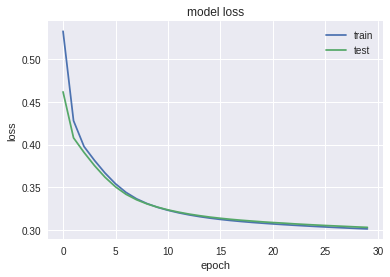

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(history)

After 10 epochs, the auto-encoder reaches a stable train/text loss value of about 0.282. Now, we are going to see how the reconstruction of the model works with visuals(images) by comparing with the original images.

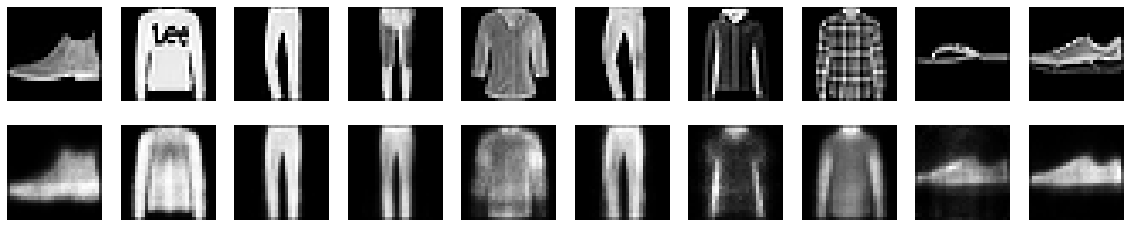

In [92]:
# encode and decode some images from test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 10)

The top row is the original image, while bottom row is the reconstructed image. We can see that we are loosing a lot of fine details.

### *Convolutional Autoencoder*

The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train the data, we are going to use the original Fashion MNIST digits with shap, and normalize the values between 0 and 1.

In [0]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Train the model

In [95]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 100us/step - loss: 0.4057 - val_loss: 0.3507
Epoch 2/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3428 - val_loss: 0.3438
Epoch 3/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3295 - val_loss: 0.3265
Epoch 4/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.3212 - val_loss: 0.3184
Epoch 5/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3156 - val_loss: 0.3140
Epoch 6/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.3117 - val_loss: 0.3096
Epoch 7/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3088 - val_loss: 0.3065
Epoch 8/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3067 - val_loss: 0.3070
Epoch 9/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.3052 - val_loss: 0.3054
Epoc

Let's take a look at the reconstructed digits:

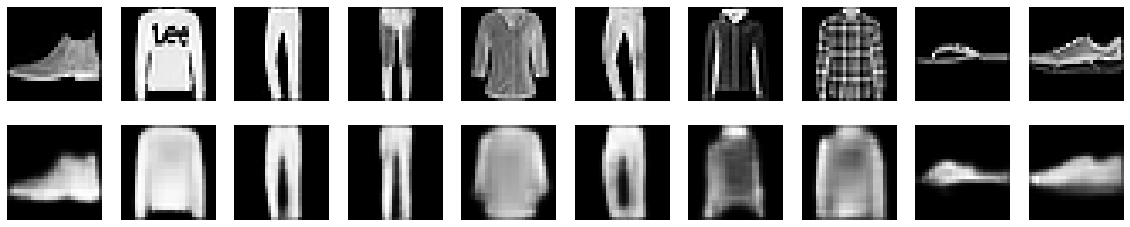

In [96]:
decoded_imgs = autoencoder.predict(x_test)
display_reconstructed(x_test, decoded_imgs, 10)


## **Problem 2**
### **Problem 2.1**

First, we need to prepare the input data from Fashion MNIST.

In [97]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


Then, we can define the lables of the data

In [0]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

In [0]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [0]:
# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

In [0]:
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
## Keras
from keras.models import Sequential
# Importing core neural networks layers 
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
# Importing CNN layers
from keras.layers import LSTM, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D
# Tools for data transformation
from keras.utils import np_utils

from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras import applications
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.datasets import fashion_mnist
model = Sequential()

In [0]:
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [105]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [107]:
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 13s 228us/step - loss: 0.5932 - acc: 0.7833 - val_loss: 2.0592 - val_acc: 0.8698
Epoch 2/10
55000/55000 [==============================] - 11s 205us/step - loss: 0.4111 - acc: 0.8509 - val_loss: 1.7955 - val_acc: 0.8860
Epoch 3/10
55000/55000 [==============================] - 11s 206us/step - loss: 0.3739 - acc: 0.8648 - val_loss: 1.6860 - val_acc: 0.8932
Epoch 4/10
55000/55000 [==============================] - 11s 205us/step - loss: 0.3468 - acc: 0.8736 - val_loss: 1.7828 - val_acc: 0.8862
Epoch 5/10
55000/55000 [==============================] - 11s 204us/step - loss: 0.3286 - acc: 0.8808 - val_loss: 1.7746 - val_acc: 0.8862
Epoch 6/10
55000/55000 [==============================] - 11s 204us/step - loss: 0.3139 - acc: 0.8838 - val_loss: 1.5704 - val_acc: 0.9002
Epoch 7/10
55000/55000 [==============================] - 11s 204us/step - loss: 0.2994 - acc: 0.8899 - val_loss: 2.0

In [0]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

In [109]:
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9089


In [0]:
y_hat = model.predict(x_test)

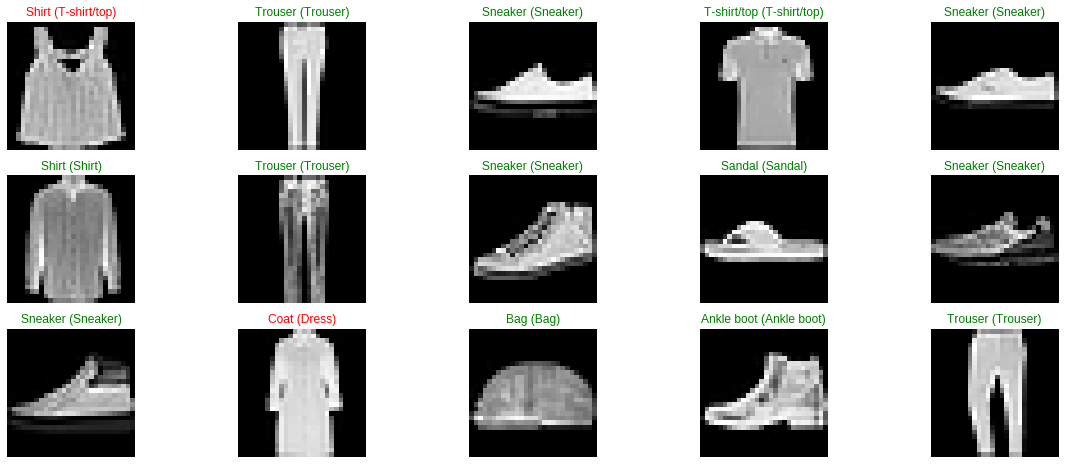

In [111]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

### **Problem 2.2**

I am going to use the VGG as a pre-trained backbone for this transfer learning. 


In [0]:
from keras.utils import np_utils
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers.core import Dense, Dropout, Activation, Lambda,Flatten, Reshape


In [113]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [114]:
x_train= np.reshape(x_train, (len(x_train), 28*28))
x_train = np.dstack([x_train] * 3)
x_test= np.reshape(x_test, (len(x_test), 28*28))
x_test = np.dstack([x_test] * 3)
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)
x_train.shape,x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Then, reshape it as follows. Please note that the VGG requires an input of three channels and 48 X 48 pixels. Hence, I reshape the dataset to (length, 48, 48, 3)

In [115]:
# Reshape image to (48,48)
from keras.preprocessing.image import img_to_array, array_to_img
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Now, we are going to build a transfer model.

In [0]:
number_of_classes = 10

vgg = VGG16(weights = "imagenet", include_top=False,  input_shape=(48, 48, 3) ,pooling='max', classes=number_of_classes)

for layer in vgg.layers[:17]:
    layer.trainable = False

x = vgg.output
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(number_of_classes, activation="softmax")(x)

# creating the final model 
vgg_model = Model(inputs = vgg.input, outputs = predictions)

In [120]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [121]:
# Training the model
batch_size = 256
epochs = 5
#model = create_model()
vgg_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = vgg_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 42s 707us/step - loss: 0.4487 - acc: 0.8385 - val_loss: 0.3372 - val_acc: 0.8767
Epoch 2/5
60000/60000 [==============================] - 41s 683us/step - loss: 0.3151 - acc: 0.8842 - val_loss: 0.3247 - val_acc: 0.8833
Epoch 3/5
60000/60000 [==============================] - 41s 684us/step - loss: 0.2766 - acc: 0.8978 - val_loss: 0.3280 - val_acc: 0.8785
Epoch 4/5
60000/60000 [==============================] - 41s 683us/step - loss: 0.2544 - acc: 0.9054 - val_loss: 0.3209 - val_acc: 0.8876
Epoch 5/5
60000/60000 [==============================] - 41s 683us/step - loss: 0.2407 - acc: 0.9106 - val_loss: 0.2858 - val_acc: 0.8946


In [122]:
print("Training accuracy = %0.05f" % vgg_model.evaluate(x_train, y_train)[1])
print("Testing accuracy = %0.05f" % vgg_model.evaluate(x_test, y_test)[1])

60000/60000 [==============================] - 52s 866us/step
Training accuracy = 0.91737
10000/10000 [==============================] - 9s 864us/step
Testing accuracy = 0.89460


The performance of the transfer learning on training set and test set are 0.91737 and 0.89460   respectively.

## **Problem 3**
### **Problem 3.1**

Upload files first.

In [0]:
import pandas as pd
benign = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt" , header = None)
malicious =  pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt", header = None)

After reading the data, I am going to preprocess the dataframe.

In [0]:
benign = benign.drop([0])
malicious = malicious.rename(columns = {0:"URL"})
benign = benign.rename(columns = {0:"URL"})
benign['Is_Malicious'] = 0
malicious['Is_Malicious'] = 1

In [164]:
df = pd.concat([benign, malicious])
df.head()

,URL,Is_Malicious
1,.0.blogger.gmodules.com,0
2,.0.client-channel.google.com,0
3,.0.docs.google.com,0
4,.0.drive.google.com,0
5,.0.gvt0.cn,0


In [165]:
from string import printable
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Bidirectional, SimpleRNN
from keras.optimizers import SGD, Adam, RMSprop
from sklearn import model_selection
from sklearn.model_selection import train_test_split



# Data preprocessing

# Convert The URLs to indices of printable characters
url_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

# maximal lenghth and padding
max_len=75
X = sequence.pad_sequences(url_tokens, maxlen=max_len)
 
# get the response
y = np.array(df.Is_Malicious)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of response: ', y.shape)

Matrix dimensions of X:  (67352, 75) Vector dimension of response:  (67352,)


In [0]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In this case, I used the Bidirectional RNN to do the classification.

In [167]:
# Input
max_len=75
emb_dim=32
max_vocab_len=100
output_size=32
W_reg=regularizers.l2(1e-4)

inp = Input(shape=(max_len,),dtype='int32')

x = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len, W_regularizer=W_reg)(inp) 
x = Bidirectional(SimpleRNN(100, 
                             return_sequences=False, 
                             dropout=0.1, 
                             recurrent_dropout=0.1))(x)
x = Dense(1, activation='sigmoid')(x)

# Setting the model
model1 = Model(inputs=inp, outputs=x)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=75, embeddings_regularizer=<keras.reg...)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 75, 32)            3200      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               26600     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 201       
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [168]:
cwd = os.getcwd()
epochs = 20
batch_size = 32

# early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='Best_BI_RNN_model.h5', monitor='val_loss', save_best_only=True)]


history1 = model1.fit(X_train, y_train, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                     callbacks=callbacks)

loss, accuracy = model1.evaluate(X_train, y_train, verbose=1)
print('\nTraining Accuracy = ', accuracy, '\n')

loss, accuracy = model1.evaluate(X_test, y_test, verbose=1)
print('\nTesting Accuracy =', accuracy, '\n')

Train on 50514 samples, validate on 16838 samples
Epoch 1/20
50514/50514 [==============================] - 269s 5ms/step - loss: 0.1099 - acc: 0.9760 - val_loss: 0.0869 - val_acc: 0.9813
Epoch 2/20
50514/50514 [==============================] - 266s 5ms/step - loss: 0.0875 - acc: 0.9802 - val_loss: 0.0732 - val_acc: 0.9813
Epoch 3/20
50514/50514 [==============================] - 265s 5ms/step - loss: 0.0780 - acc: 0.9795 - val_loss: 0.0637 - val_acc: 0.9811
Epoch 4/20
50514/50514 [==============================] - 266s 5ms/step - loss: 0.0704 - acc: 0.9794 - val_loss: 0.0584 - val_acc: 0.9813
Epoch 5/20
50514/50514 [==============================] - 267s 5ms/step - loss: 0.0624 - acc: 0.9797 - val_loss: 0.0522 - val_acc: 0.9811
Epoch 6/20
50514/50514 [==============================] - 267s 5ms/step - loss: 0.0565 - acc: 0.9799 - val_loss: 0.0488 - val_acc: 0.9818
Epoch 7/20
50514/50514 [==============================] - 268s 5ms/step - loss: 0.0524 - acc: 0.9811 - val_loss: 0.0432 - 

The training and testing accuracies are 0.9903 and 0.9899 respectively, which are very high.

In [0]:
## Using Different URLs to test the model
test_url_mal = ".btscene2.com"
test_url_benign = "www.cnn.com"

In [0]:
def test_url(url, model):
  # Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
  url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable]]

  # Step 2: Cut URL string at max_len or pad with zeros if shorter
  max_len=75
  X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
  proba = model.predict(X, batch_size=1)
  if proba > 0.5:
        result = "malicious"
  else:
        result = "benign"
  print("Test URL:", url, "is",result)

In [171]:
test_url(test_url_mal,model1)
test_url(test_url_benign,model1)

Test URL: .btscene2.com is malicious
Test URL: www.cnn.com is benign


From the test above, the model detects malicious URLs from the benign URLs.



### **Problem 3.2**

In [0]:
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, BatchNormalization, Convolution1D, MaxPooling1D, concatenate

In [173]:
# Input
max_len=75
emb_dim=32
max_vocab_len=100
output_size=32
W_reg=regularizers.l2(1e-4)

inp = Input(shape=(max_len,),dtype='int32')

x = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len, W_regularizer=W_reg)(inp) 

# CNN
x =Convolution1D(kernel_size=5, filters=256, border_mode='same')(x)
x = ELU()(x)
x = MaxPooling1D(pool_size=4)(x)
x = Dropout(0.1)(x)

# LSTM
x = LSTM(output_size)(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)

# Setting the model
model2 = Model(inputs=inp, outputs=x)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=75, embeddings_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, filters=256, padding="same")`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 75, 32)            3200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 75, 256)           41216     
_________________________________________________________________
elu_4 (ELU)                  (None, 75, 256)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 18, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                36992     
__________

In [174]:
cwd = os.getcwd()
epochs = 20
batch_size = 64

# early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='Best_CNN_LSTM_model.h5', monitor='val_loss', save_best_only=True)]


history2 = model2.fit(X_train, y_train, epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                     callbacks=callbacks)
  

loss, accuracy = model2.evaluate(X_train, y_train, verbose=1)
print('\nTraining Accuracy = ', accuracy, '\n')

loss, accuracy = model2.evaluate(X_test, y_test, verbose=1)
print('\nTesting Accuracy =', accuracy, '\n')

Train on 50514 samples, validate on 16838 samples
Epoch 1/20
50514/50514 [==============================] - 61s 1ms/step - loss: 0.1380 - acc: 0.9794 - val_loss: 0.0734 - val_acc: 0.9813
Epoch 2/20
50514/50514 [==============================] - 58s 1ms/step - loss: 0.0687 - acc: 0.9806 - val_loss: 0.0598 - val_acc: 0.9813
Epoch 3/20
50514/50514 [==============================] - 58s 1ms/step - loss: 0.0506 - acc: 0.9806 - val_loss: 0.0382 - val_acc: 0.9815
Epoch 4/20
50514/50514 [==============================] - 57s 1ms/step - loss: 0.0311 - acc: 0.9854 - val_loss: 0.0256 - val_acc: 0.9874
Epoch 5/20
50514/50514 [==============================] - 58s 1ms/step - loss: 0.0249 - acc: 0.9889 - val_loss: 0.0226 - val_acc: 0.9892
Epoch 6/20
50514/50514 [==============================] - 57s 1ms/step - loss: 0.0224 - acc: 0.9898 - val_loss: 0.0214 - val_acc: 0.9896
Epoch 7/20
50514/50514 [==============================] - 57s 1ms/step - loss: 0.0209 - acc: 0.9905 - val_loss: 0.0205 - val_acc

The training and testing accuracies are 0.9932 and 0.9915, which are very high as well.

In [175]:
test_url(test_url_mal,model2)
test_url(test_url_benign,model2)

Test URL: .btscene2.com is malicious
Test URL: www.cnn.com is benign


The CNN+LSTM model's accuracy is higher than the previous one.



### **Problem 3.3**

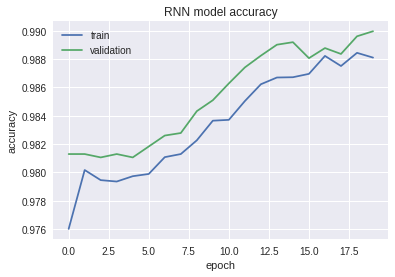

In [177]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

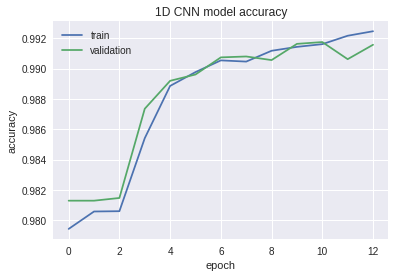

In [180]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('1D CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

By comparing two models, we can note that the 1D CNN model has a higher accuracy than the RNN model. It is also interesting to see that the decrease in loss is more stable for 1D CNN model.

### **Reference**

1. https://blog.keras.io/building-autoencoders-in-keras.html
2. Melissa K. (2017). Featureless Deep Learning for Detection of Malicious URLs. https://github.com/incertum/cyber-matrix-ai/tree/master/Malicious-URL-Detection-Deep-Learning

Please note that I collaborated this work with Ratnadeep Mitra(rm1773).